In [1]:
import dataloader
import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sample_x, sample_y = dataloader.generate_data_tf(isTrain=True, batch_size=128)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

#internal neural network parameters
input_seq_length = sample_x.shape[0]
output_seq_length = sample_y.shape[0]
seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 128  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

input_dim = sample_x.shape[-1]
output_dim = sample_y.shape[-1]
print('inp_dim', input_dim)
print('out_dim', output_dim)
#output_dim = input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 128  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 3  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 1000  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

#print(dataloader.scaler.data_min_)

# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")


c:\users\deyan\tf-workspace\env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Dimensions of the dataset for 3 X and 3 Y training examples : 
(864, 128, 17)
(24, 128, 1)
(seq_length, batch_size, output_dim)
inp_dim 17
out_dim 1
Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow's version : 1.0 (or more)


In [2]:

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(input_seq_length)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(output_seq_length)
    ]
    
    # Give a "GO" token to the decoder. 
    # Note: we might want to fill the encoder with zeros or its own feedback rather than with "+ enc_inp[:-1]"
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            #cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            cells.append(tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    # For reshaping the output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # Final outputs: with linear rescaling for enabling possibly large and unrestricted output values.
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]


In [3]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)


In [4]:

def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=True, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 50 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/1000, train loss: 424.584716796875, 	TEST loss: 9.703180313110352
Step 50/1000, train loss: 6.931334495544434, 	TEST loss: 4.476178169250488
Step 100/1000, train loss: 3.5148234367370605, 	TEST loss: 6.115015029907227
Step 150/1000, train loss: 3.124358654022217, 	TEST loss: 4.580804824829102
Step 200/1000, train loss: 2.1840660572052, 	TEST loss: 3.9642417430877686
Step 250/1000, train loss: 2.1792006492614746, 	TEST loss: 3.610426187515259
Step 300/1000, train loss: 2.269029378890991, 	TEST loss: 3.627967357635498
Step 350/1000, train loss: 1.768946647644043, 	TEST loss: 3.5105438232421875
Step 400/1000, train loss: 1.8051371574401855, 	TEST loss: 3.6931190490722656
Step 450/1000, train loss: 1.6321052312850952, 	TEST loss: 4.889244079589844
Step 500/1000, train loss: 3.7005410194396973, 	TEST loss: 2.204608917236328
Step 550/1000, train loss: 1.4237937927246094, 	TEST loss: 2.566679000854492
Step 600/1000, train loss: 1.3111188411712646, 	TEST loss: 2.4264230728149414
Step 65

In [6]:
saver = tf.train.Saver()
save_path = saver.save(sess, "nn_models/tf/1000_iter.ckpt")


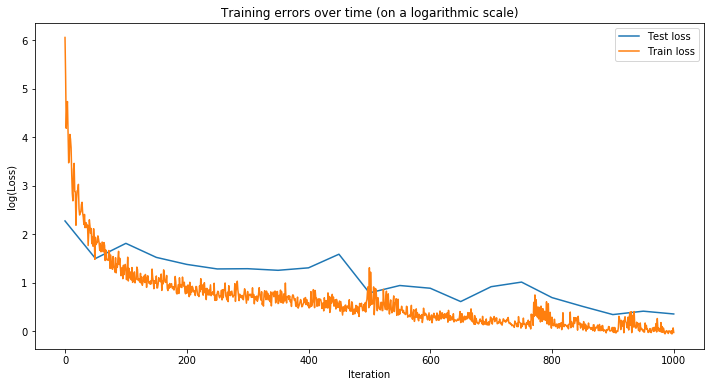

In [7]:

# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


In [18]:
def count_number_trainable_params():
            tot_nb_params = 0
            for trainable_variable in tf.trainable_variables():
                shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
                current_nb_params = get_nb_params_shape(shape)
                tot_nb_params = tot_nb_params + current_nb_params
            return tot_nb_params

def get_nb_params_shape(shape):
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params

count_number_trainable_params()

675970

In [21]:
len(dec_outputs)

864

Let's visualize 5 predictions with our signals:
(864, 5, 17) (24, 5, 1)
outputs_shape (864, 5, 1)
(864,) (24,) (864,)


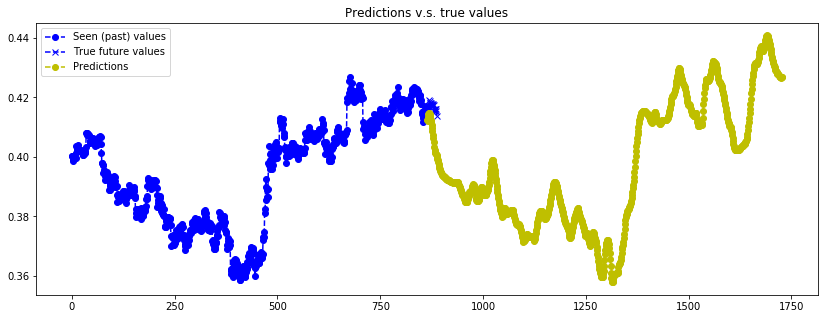

(864,) (24,) (864,)


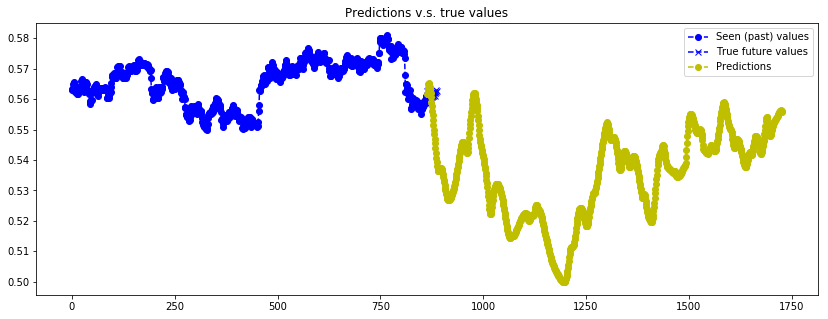

(864,) (24,) (864,)


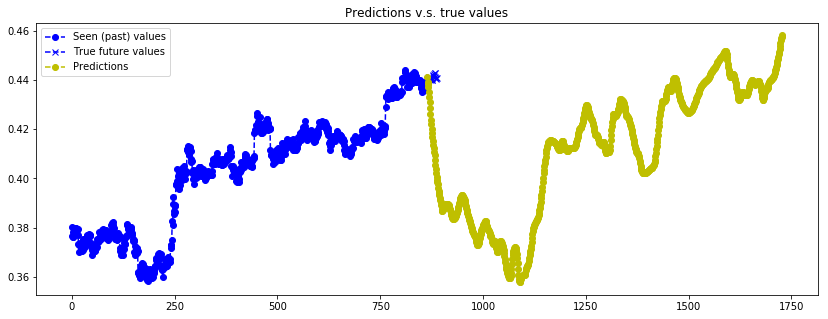

(864,) (24,) (864,)


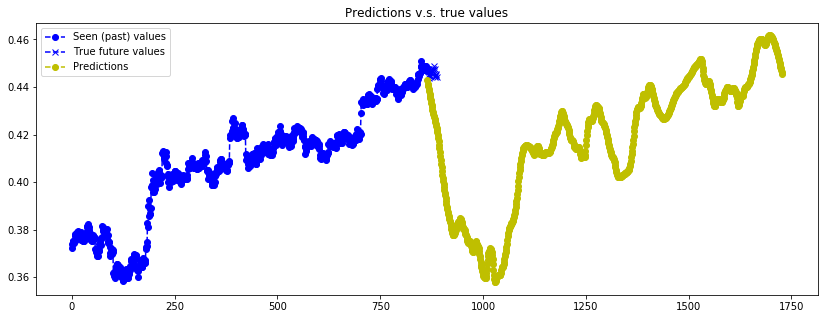

(864,) (24,) (864,)


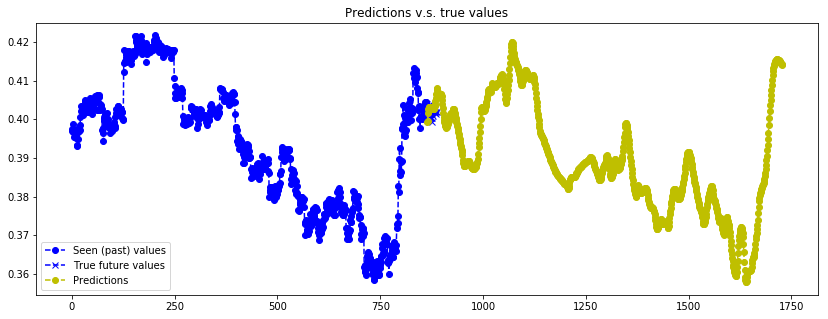

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [15]:
# Test
nb_predictions = 5
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=nb_predictions)
print(X.shape, Y.shape)
feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print('outputs_shape', outputs.shape)


for j in range(nb_predictions): 
    plt.figure(figsize=(14, 5))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        print(past.shape, expected.shape, pred.shape)
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")